# Electrofacies prediction model

* [Problem description](#Problem-description)
* [Markup filtration](#Markup-filtration)
* [Dataset creation](#Dataset-creation)
* [Model architecture](#Model-architecture)
* [Model training](#Model-training)
* [Inference](#Inference)
* [Metrics evaluation and results visualization](#Metrics-evaluation-and-results-visualization)

___
## Problem description

Predict electrofacies based on Spontaneous well log.

Goal: predict pattern of elecrofacies changes using only SP log. Well data and markup must be pre-processed before training the model.

Tables of electrofacies and their indices, which will be used in this notebook:


|    Index   | Facie                                    |
|------------|------------------------------------------|
| 0          | Shallow marine, шельфовые, баровые       |
| 1          | Краевые части песчаных тел (баров)       |
| 2          | Лагунные и склоновые глинистые отложения |
| 3          | Промоины разрывных течений               |
| 4          | Transition zone                          |
| 5          | Склоновые врезы                          |

In [1]:
import os
import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.metrics import classification_report

sys.path.append("../../../")
from petroflow import WellDataset, WS, Well
from petroflow.batchflow import Pipeline, B, V
from petroflow.batchflow.models.torch import UNet
from petroflow.batchflow.models.torch.losses import CrossEntropyLoss

from pylab import rcParams
rcParams['figure.figsize'] = 15, 7
pd.options.mode.chained_assignment = None

In [2]:
%env CUDA_VISIBLE_DEVICES=4

env: CUDA_VISIBLE_DEVICES=4


In [3]:
path = 'path/to/facies_dataset/'
markup_path = 'path/to/markup1.xlsx'
markup2_path = 'path/to/markup2.xlsx'

Load 2 markup files. One contain top and bottom of facies mask interval, another only bottom. 
One row corresponding one well with markup of one interval of one electrofacie. 

Shift indices of facies  from [1, n]  to [0, n-1].

In [4]:
markup = pd.read_excel(markup_path, index_col=0)
markup.index = markup.index.map(str)
markup['facies code'] -= 1

In [5]:
markup2 = pd.read_excel(markup2_path, names=['Well', 'кровля bv08', 'facies code'], index_col=0)
markup2.index = markup2.index.map(str)
markup2['facies code'] -= 1

In [6]:
markup2['facies code'].value_counts()

0    666
3    202
1    182
4     94
2     31
5      6
8      1
6      1
Name: facies code, dtype: int64

In [7]:
markup['facies code'].value_counts()

0    751
4    266
1    208
3    174
2    115
5     28
Name: facies code, dtype: int64

___
## Markup filtration

Define functions to filter markup data:
- `add_bottom` - add bottom column of facies mask in **pd.DataFrame**. Bottom it is last index with not nan value of SP log (if well in markup does't exist or SP log of well doesn't exist then drop that markup);
- `del_markup_wo_wells` - drop rows of **pd.DataFrame** corresponding missing wells;
- `del_markup_wo_logs` -  drop rows of **pd.DataFrame** corresponding wells with missing SP log;
- `del_outward_markup` - drop rows of **pd.DataFrame** corresponding mask which beyond outside top or bottom of well.

In [8]:
def add_bottom(marking):
    list_bottoms = []
    for well in marking.index:
        try:
            w = Well(path + well)
            bottom = w.iter_level()[0].logs['SP'].last_valid_index()
            list_bottoms.append(bottom)
        except (FileNotFoundError, KeyError):
            list_bottoms.append(np.nan)
    marking.insert(1, 'подошва bv08', list_bottoms) 
    marking = marking[marking['подошва bv08'].isna() == False]
    return marking

In [9]:
def del_markup_wo_wells(marking):
    existing_wells = set(os.listdir(path))
    markup_wells = set(marking.index)
    marking = marking.loc[existing_wells & markup_wells]
    return marking

In [10]:
def del_markup_wo_logs(marking):
    for well in marking.index:
        w = Well(path+well)
        try:
            w.segments[0].logs['SP']
        except KeyError:
            marking.drop(well, inplace=True)
    return marking

In [11]:
def del_outward_markup(marking):
    for well in marking.index:
        w = Well(path + well)
        markup_w = marking.loc[well]
        start, stop = float(markup_w['кровля bv08']),  float(markup_w['подошва bv08'])
        if start < w.depth_from or stop > w.depth_to:
            marking.drop(well, inplace=True)
    return marking

Leave markup only for existing facies. Apply filtering markup functions and concatenate 2 markup **pd.DataFrame**.

In [12]:
markup2 = markup2[markup2['facies code'] < 6]
markup2 = add_bottom(markup2)
markup = del_markup_wo_wells(markup)
markup = del_markup_wo_logs(markup)
markup = pd.concat([markup2, markup])
markup = del_outward_markup(markup)

Now we have clear markup with 6 facies.

---
## Dataset creation

In [13]:
DATASET_PATH = [path + well for well in markup.index]

In [14]:
ds = WellDataset(path=DATASET_PATH, dirs=True, sort=True)

Define class `FilteringUtils` with functions to preprocess dataset. Functions:
 - `add_mask_to_logs` -  add column 'MASK' to `WellSegemnt.logs` with mapped mask from markup;
 - `mask_creator` -  create attribute `WellSegment.mask` with value from `WellSegment.logs['MASK']`;
 - `single_crop` - do one crop with length `length` from `WellSegemnt.depth_from`.

In [15]:
class FilteringUtils:
    @classmethod
    def add_mask_to_logs(self, batch, mapping, tol=1e-3):
        for well in batch.wells:
            for segment in well.iter_level():
                name = segment.name
                segment.logs['MASK'] = np.nan
                mask_from, mask_to, facie  = markup.loc[name]['кровля bv08'], markup.loc[name]['подошва bv08'], markup.loc[name]['facies code']
                segment._logs['MASK'][mask_from-tol:mask_to+tol] = mapping[facie]
                
    @classmethod            
    def mask_creator(self, batch, column='MASK', mask_attr='mask'):
        for well in batch.wells:
            for segment in well.iter_level():
                setattr(segment, mask_attr, segment.logs['MASK'].to_numpy())
                
    @classmethod 
    def single_crop(self, batch, length):
        for well in batch.wells:
            well.segments = [segment[segment.depth_from:segment.depth_from+length] for segment in well.iter_level()]

Define `CROP_SIZE=15` meters because pattern of electrofacies changes consist in this crop. And we want pred

Examples of 2, 4, 5 classes are few. Define `mapping` to combine 2, 4, 5 classes into 2 сlass to get more balanced dataset.

Define `N_CLASSES` to further define model configuration and plot result graphics.

In [16]:
CROP_SIZE = 15
mapping = {0: 0, 
           1: 1, 
           2: 2, 
           3: 3, 
           4: 2, 
           5: 2}
N_CLASSES = len(set(mapping.values()))

Dataset filtering:

In [17]:
filtering_pipeline = (Pipeline()
            .add_namespace(FilteringUtils)
            .keep_logs("SP")
            .add_mask_to_logs(B(), mapping)
            .drop_nans(['SP', 'MASK'])
            .drop_short_segments(CROP_SIZE)
            .single_crop(B(), CROP_SIZE)
            .mask_creator(B())
            .keep_logs('SP')) << ds

filtered_batch = filtering_pipeline.next_batch(len(ds))

SP log percentile (1 and 99) are calculated for further scaling:

In [18]:
train_logs = pd.concat([seg.logs['SP'] for well in filtered_batch._data[0] for seg in well.iter_level()])
p1 = train_logs.quantile(.01)
p99 = train_logs.quantile(.99)
p1, p99

(15.242970000000001, 229.94)

Define function for building `WellDataset` from loaded data of batch.

In [19]:
def build_dataset(batch):
    preloaded = ({k: v for k, v in zip(batch.indices, batch.wells)},)
    ds = WellDataset(index=batch.index, preloaded=preloaded)
    return ds

Scale dataset values to range between zero and one. Scale 1 percentile to 0 and 99 percentile to 1. Values not in range 1-99 percentiles are clipped.

In [20]:
filtered_ds = build_dataset(filtered_batch)

scaling_pipeline = Pipeline().norm_min_max(p1, p99) << filtered_ds
preprocessed_batch = scaling_pipeline.next_batch(len(filtered_ds))

Filtered and scaled dataset is split into training and testing subsets with an 80:20 ratio.

In [21]:
preprocessed_ds = build_dataset(preprocessed_batch)
preprocessed_ds.split([0.8, 0.2])

print("The number of wells in the train dataset:", len(preprocessed_ds.train))
print("The number of wells in the test dataset:", len(preprocessed_ds.test))

The number of wells in the train dataset: 1555
The number of wells in the test dataset: 389


---

## Model architecture

UNet model is used to predict formation porosity (https://analysiscenter.github.io/batchflow/api/batchflow.models.torch.unet.html).

Model configuration:
* input shape - [1, 150] (15 meters of SP log)
* output shape - [1, 150] - predicted facies indices mask 
* the number of filters in encoder and corresponding decoder blocks - [32, 64, 128, 256]
* each encoder and decoder block has "cna cna" layout with a kernel size of 3 and a ReLU activation
* downsampling in the encoder is performed by a max pooling operation with a kernel size and a stride of 2
* upsampling in the decoder is performed by a transposed convolution with a kernel size of 4 and a stride of 2, followed by batch normalization and a ReLU activation.

Adam optimizer with default parameters is used for model training. Weighted cross entropy is used as a loss function. Loss function classes weights -  [1.3, 5, 4, 4].

Model configuration specification:

In [22]:
model_config = {
    "initial_block/inputs": "images",
    "head/num_classes": N_CLASSES,
    "inputs": dict(images={"shape": (1, CROP_SIZE * 10)}, 
                   target={"shape": (1, CROP_SIZE * 10)}),
    "body/filters": [32, 64, 128, 256],
    "body/encoder": dict(layout="cnacna", kernel_size=3),
    "body/decoder": dict(layout="cnacna", kernel_size=3),
    "body/upsample": dict(layout="tna", kernel_size=2, strides=2),
    "head": dict(layout="c"),
    "loss": {'name': CrossEntropyLoss, 
             'weight': torch.Tensor([1.3, 5, 4, 4])},
    "optimizer": "Adam",
    "output": 'labels',
    'device': 'gpu:0'
}

## Model training

The model is trained for 1000 epochs with a batch size of 50.

In [23]:
BATCH_SIZE = 50
N_EPOCHS = 1000

Training pipeline specification:

In [24]:
template_train = (Pipeline()
            .add_namespace(np)
            .update(B("mask"), WS("mask").ravel())
            .stack(B("mask"), save_to=B("mask"))        
            .update(B("logs"), WS("logs").ravel())
            .stack(B("logs"), save_to=B("logs"))
            .swapaxes(B("logs"), 1, 2, save_to=B("logs"))
            .array(B("logs"), dtype=np.float32, save_to=B("logs"))
            .train_model("unet", B('logs'), B('mask'), fetches='loss',
                          save_to=V("history", mode="a"), use_lock=True)
           ) << preprocessed_ds.train

In [25]:
(template_train.before
.init_model("dynamic", UNet, name="unet", config=model_config)
.init_variable("history", default=[]))

In [26]:
(template_train.after
.save_model('unet', path='model_4class.torch'))

Model training:

In [27]:
template_train.run(BATCH_SIZE, n_epochs=N_EPOCHS, bar=True, shuffle=True, drop_last=True)

100%|██████████| 31000/31000 [18:45<00:00, 27.54it/s]


Loss function against the number of epochs:

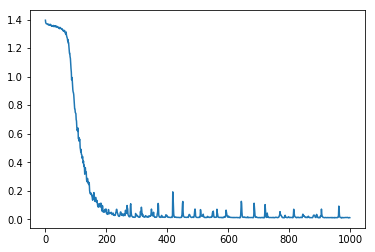

In [28]:
plt.plot(np.array(np.split(np.array(template_train.v('history')[:]), N_EPOCHS)).mean(axis=1))

Training loss almost reaches a plateau by the end of the training, meaning that the learning process has converged.

___
## Inference

Inference pipeline is similar to a combination of filtering and training pipelines, except adding pipeline variables for further evaluation.

In [29]:
template_predict = (Pipeline()
            .add_namespace(np)
            .import_model('unet', template_train)
            .update(B("mask"), WS("mask").ravel())
            .stack(B("mask"), save_to=B("mask"))        
            .update(B("logs"), WS("logs").ravel())
            .stack(B("logs"), save_to=B("logs"))
            .swapaxes(B("logs"), 1, 2, save_to=B("logs"))
            .array(B("logs"), dtype=np.float32, save_to=B("logs"))
            .predict_model("unet", B("logs"), fetches="labels", save_to=V("pred", mode="e"))
            .update(V("logs", mode="e"), B("logs"))
            .update(V("true", mode="e"), WS("mask").ravel())
) << preprocessed_ds.test

In [30]:
(template_predict.before
 .init_variable("true", default=[])
 .init_variable("pred", default=[])
 .init_variable("logs", default=[]))

In [31]:
template_predict.run(1, n_epochs=1, bar=True, shuffle=False, drop_last=False)

100%|██████████| 389/389 [00:03<00:00, 109.81it/s]


___
## Metrics evaluation and results visualization

Classification report shows a representation of the main classification metrics on a per-class basis.

In [32]:
true = np.concatenate(template_predict.v("true"))
pred = np.concatenate(template_predict.v("pred"))

In [33]:
print(classification_report(true, pred))

              precision    recall  f1-score   support

         0.0       0.64      0.77      0.70     36600
         1.0       0.12      0.10      0.11      4650
         2.0       0.13      0.07      0.09      8250
         3.0       0.15      0.11      0.12      8850

    accuracy                           0.52     58350
   macro avg       0.26      0.26      0.26     58350
weighted avg       0.45      0.52      0.48     58350



Vizialize true mask, predicted mask and SP log of crop. Use `idx` to choose crop.

In [34]:
true_crop_mask = template_predict.v("true")
pred_crop_mask = template_predict.v("pred")
crop_logs = np.concatenate(template_predict.v("logs"))

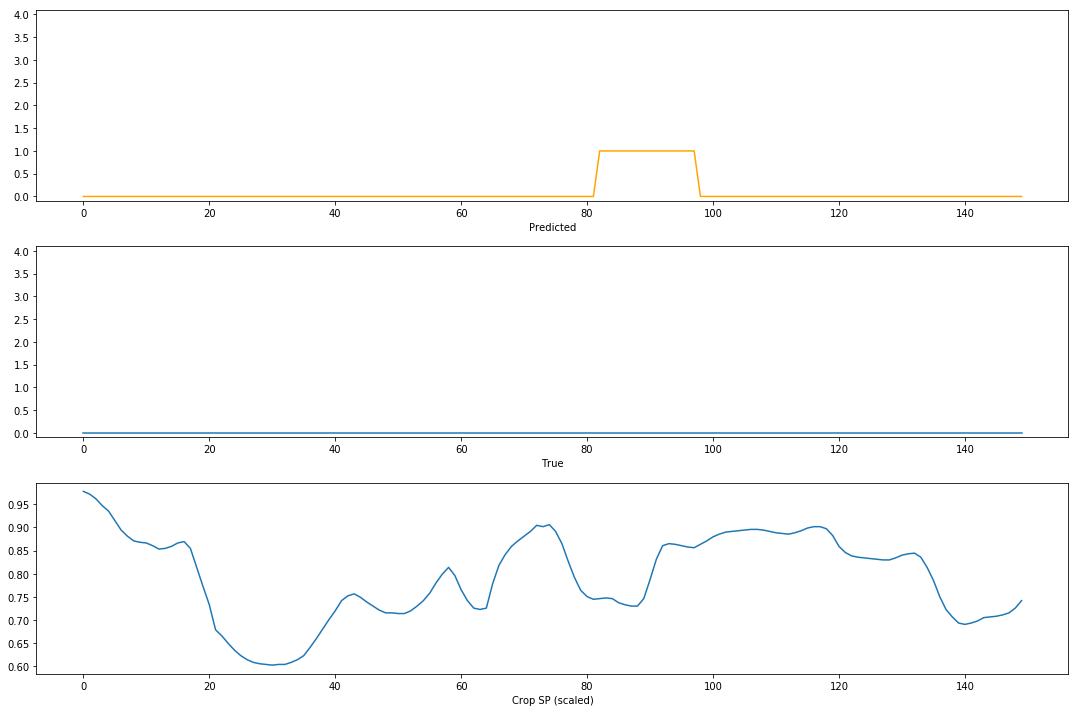

In [35]:
idx = 107  # index of crop

tol = 0.1
fig, axs = plt.subplots(3, 1, figsize=(15,10))

axs[0].plot(pred_crop_mask[idx], color='orange')
axs[0].set_xlabel('Predicted')

axs[1].plot(true_crop_mask[idx])
axs[1].set_xlabel('True')

axs[2].plot(crop_logs[idx])
axs[2].set_xlabel('Crop SP (scaled)')

axs[0].set_ylim(-tol, N_CLASSES + tol)
axs[1].set_ylim(-tol, N_CLASSES + tol)
# axs[2].set_ylim(0, 1)

fig.tight_layout()